# Tutorial 04 - Medical Ultrasound - Calculate travel times using the USCT setup

This exercise illustrate that the methods used in seismics are ubiquitous in many other research areas. Therefore, understanding the methods asslows one to bridge the gap between different fields of research.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import h5py
import pestoseis.ttimerays as tr

## Problem Setup

In this exercise, the input velocity model describes the speed-of-sound distribution within a breast phantom that mimicks a cross-sectional slice through a breast. The phantom shapes are kept desiberately simple in order to be able to evaluate the accuracy of the calculated travel times. Such setups are for instance used in breast screening applications using ultrasound computed tomography (USCT) (e.g. [Ulrich et al., 2022](https://doi.org/10.1121/10.0011540)). 

First, we start off by importing our data and gridding the domain:

In [2]:
filename = f'../inputdata/breast_model.h5'
print(filename)

with h5py.File(filename,"r") as f:
    velmod = np.array(f["true_model"]["velomod"])

../inputdata/breast_model.h5


Let's make a circular source-receiver array. In USCT we have a lot more freedom compared to the seismic application when it comes to the design of our experiement. In particular, we have the possibility to illuminate the unknown object from all angles. Additionaly, it is common to have transducer elements that can be used in transmit as well as in receive mode. Therefore the source and receivers are usually at the same location around the breast phantom. For this experiment however, we move the receiver positions inside the source array, since PestoSeis cannot candle coniciding source-receiver positions. 

In [3]:
nrec = 100 # number of receivers
nsrc = 100 # number of sources
rsrc = 0.075 # Radius of source array [m]
rrec = 0.073 # Radius of receiver array [m]
phi = np.arange(0,2 * np.pi,2 * np.pi / float(nsrc)) # angle 
x_src = rsrc * np.cos(phi) 
y_src = rsrc * np.sin(phi)
x_rec = rrec * np.cos(phi) 
y_rec = rrec * np.sin(phi)

sources = np.array([x_src, y_src])
receivers = np.vstack((np.array([(x_rec[0], y_rec[0])]), np.array([(x_rec[50], y_rec[50])])))

In [4]:
### setup grid object
nx = 200
ny = 200
dh = 0.001
xinit = -0.1
yinit = -0.1
gridpar = tr.setupgrid(nx,ny,dh,xinit,yinit)

## Compute the Traveltimes

Similar to in the previous exercise, we want to compute the traveltimes for the different source-receiver positions. Let's first take a look at our setup!

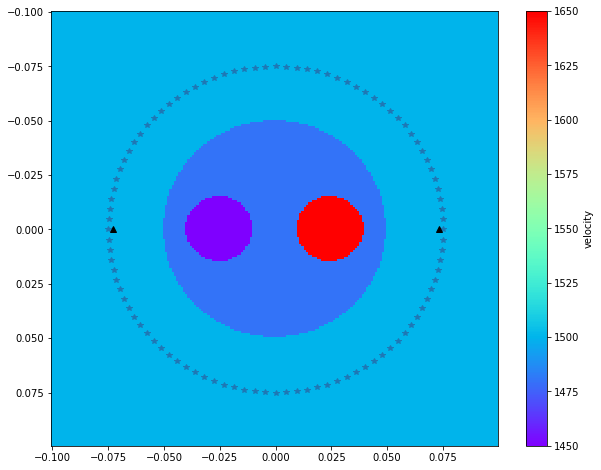

In [5]:
plt.figure(figsize=(10,8))
tr.plotvelmod(gridpar,velmod,vmin=1450,vmax=1650)
plt.plot(sources[0,:],sources[1,:],"*")
plt.plot(receivers[0,0],receivers[0,1],"^k")
plt.plot(receivers[1,0],receivers[1,1],"^k")

We first compute the travel times to all the receivers by solving the Eikonal euqtaion:<br>

$$|\nabla t(\mathbf{x})|^2=\big(\frac{\partial t(\mathbf{x})}{\partial x_1}\big)^2+\big(\frac{\partial t(\mathbf{x})}{\partial x_2}\big)^2=\frac{1}{c(\mathbf{x})^2}\;\;\;\text{with}\;\mathbf{x}\in\mathbb{R}^2, \mathbf{x}=[x_1,x_2]^{\text{T}}.$$

Note that this equation is non-linear due to the explicit dependency of the path on the velocity model. We therefore need to include the velocity model in the travel time calculation as seen below.  

In [6]:
# this function needs the shapes of the source and the receiver arrays to match along the second axis
ttpick,ttime = tr.traveltime(velmod, gridpar, sources.T, receivers)

Calculating traveltime for source 100 of 100 


## Trace the Rays

Now that we have the traveltimes we can trace the rays to see the ray paths throughout the domain. In PestoSeis, we have the possibility to trace bent rays, as well as straight rays. Bent rays obay Fermat's principle stating that the travel time along a path is minimized. To compute the bent ray paths from the previously obtained travel times, a ray is traced back from a receiver to each source location by stepping in the negative direction of the spatial gradient of the travel times. Once the backtraced ray hits a cell boundary, the spatial travel time gradient is again evaluated on the entire grid and the ray is advanced until it hits another boundary. This is executed until the ray hits the source position. 

In [7]:
# this function needs the shapes of the source and the receiver arrays to match along the SECOND axis
rays = tr.traceallrays(gridpar, sources.T, receivers, ttime)

tracing rays for source 100 of 100     


In [8]:
# this function needs the shapes of the source and the receiver arrays to match along the FIRST axis
straightrays = tr.traceall_straight_rays(gridpar, sources.T, receivers)

tracing rays for source 100 of 100     


## Plot the Results

We can not plot the following results:
- The traveltimes for each receiver receiver position
- The ray paths travelled through the domain

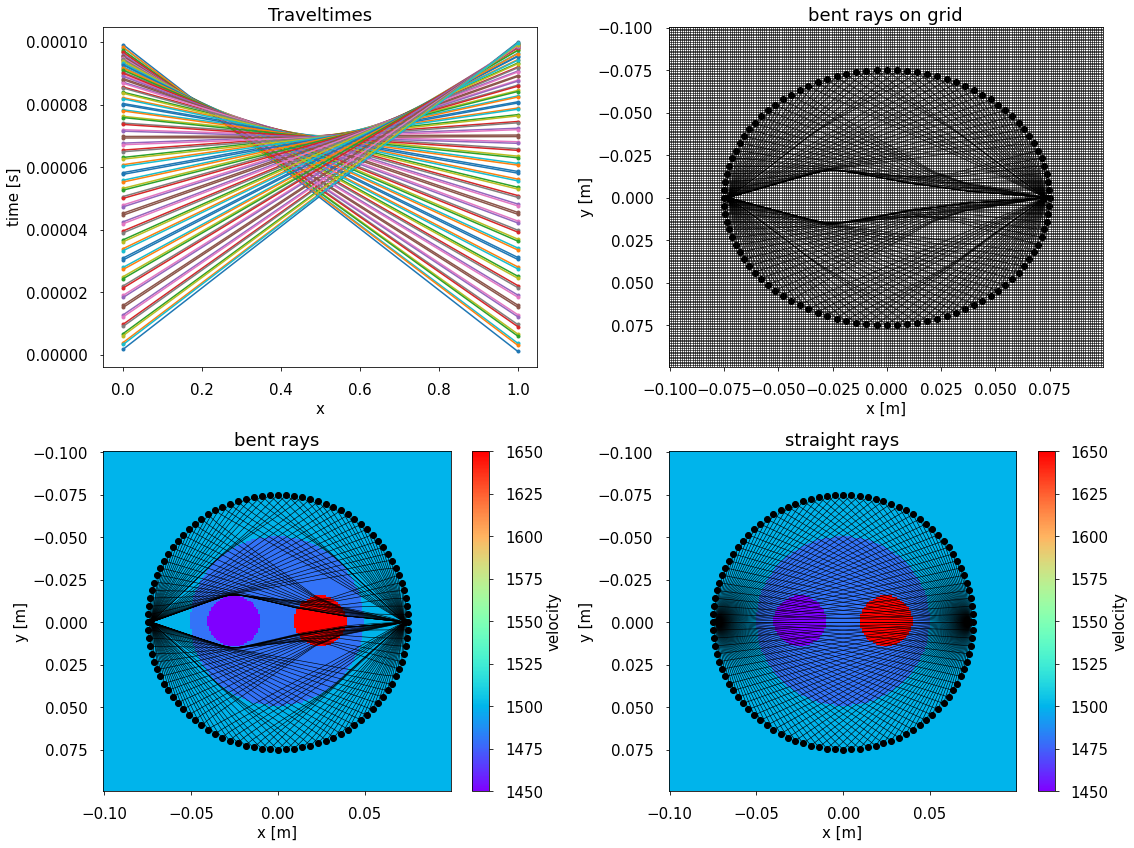

In [15]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(16,12))
gs = gridspec.GridSpec(2, 2)
plt.subplot(gs[0, 0]) 
plt.title('Traveltimes')
for i in range(ttpick.size):
    plt.plot(ttpick[i][:],'.-',label='src {}'.format(i))
plt.xlabel("x")
plt.ylabel("time [s]")

plt.subplot(gs[0,1]) 
tr.plotrays(sources.T,receivers,rays)
tr.plotgrid(gridpar)
plt.title("bent rays on grid")
plt.xlabel("x [m]")
plt.ylabel("y [m]")


plt.subplot(gs[1,0]) 
tr.plotvelmod(gridpar,velmod,vmin=1450,vmax=1650)
tr.plotrays(sources.T,receivers,rays)
plt.title("bent rays")
plt.xlabel("x [m]")
plt.ylabel("y [m]")

plt.subplot(gs[1,1]) 
tr.plotvelmod(gridpar,velmod,vmin=1450,vmax=1650)
tr.plotrays(sources.T,receivers,straightrays)
plt.title("straight rays")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
fig.tight_layout(pad=1.0)

plt.show()

In [10]:
def nice_ray_plot(src,rec,rays1,rays2) :
    """
    Plot rays as polylines.

    :param src: coordinates of the sources
    :param rec: coordinates of the receivers
    :param rays: seismic rays, as outputted by traceallrays()

    """
    for j in range(rays1.shape[1]) :
        plt.plot(src[j,0],src[j,1],'*k',zorder=100)
        for i in range(rays1.shape[0]) :
            plt.plot(rays1[i,j]['xy'][:,0],
                      rays1[i,j]['xy'][:,1],'--',color='black',linewidth=1.5, label="straight ray" if i==0 and j==0 else "")
            plt.legend()
#         for k in range(rays2.shape[0]) :
#             plt.plot(rays[k,j]['xy'][:,0],
#                       rays2[k,j]['xy'][:,1],'-',color='black',linewidth=1.5, label="bent ray" if k==0 and j==0 else "")
#             plt.legend()
        for r in range(rec.shape[0]) :
            plt.plot(rec[r,0],rec[r,1],'vk',zorder=100)
    return

In [11]:
def nice_velmod_plot(gridpar,velmod,vmin=None,vmax=None) :
    """
    Plot velocity model as an image.

    :param gridpar: grid parameters dictionary (as defined by setupgrid())    
    :param velmod: velocity model
    :param vmin,vmax: optional values to clip the colorbar min and max values

    """
    if vmin==None and vmax==None :
        vmin=velmod.min()
        vmax=velmod.max()

    extent_vel = [gridpar['xvelmin']-gridpar['dh']/2.0,gridpar['xvelmax']+gridpar['dh']/2.0,
                  gridpar['yvelmax']+gridpar['dh']/2.0,gridpar['yvelmin']-gridpar['dh']/2.0 ]
    plt.imshow(velmod.T,interpolation='nearest',extent=extent_vel,
              origin='upper',cmap="seismic",aspect='auto',vmin=vmin-100,vmax=vmax+100)
    cb=plt.colorbar()
    cb.set_label('c[m/s]')
    return

Text(0.5, 1.0, 'Ray paths')

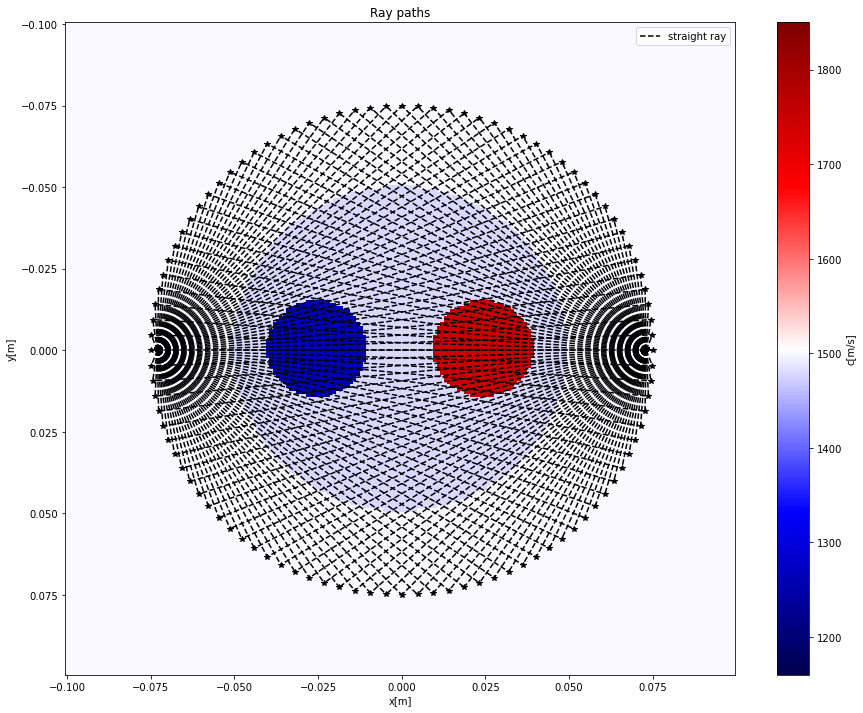

In [12]:
plt.figure(figsize=(15,12))
nice_velmod_plot(gridpar,velmod)
nice_ray_plot(sources.T,receivers,straightrays,rays)
plt.xlabel("x[m]")
plt.ylabel("y[m]")
plt.title("Ray paths")

## References

Ulrich, I. E., Boehm, C., Zunino, A., Bösch, C., Fichtner, A., "Diffuse ultrasound computed tomography", 2022, The Journal of the Acoustical Society of America, https://doi.org/10.1121/10.0011540